# Individual Project Fourth Draft

Doing what we did in third draft but cleaned up

**Summary:**

Referring to the Eager Few Shot tutorial from TF Object Detection API to load the Faster ResNet50 R-CNN 640x640 model and run some training. Gradient is returned as zero because of the adversarial attachment PIL method - GradientTape cannot "record" a Python function.

## Setup

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

import os
import random

from six import BytesIO
from six.moves.urllib.request import urlopen

In [ ]:
# TensorFlow Object Detection API installation
%%capture
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# Test: Object Detection API
%%capture
%%bash
python models/research/object_detection/builders/model_builder_tf2_test.py

##Adversarial Patch

Create a variable tensor using random generator, and provide functions to attach the adversarial patch onto images in a dataset

In [ ]:
random = tf.random.Generator.from_seed(1)
adversarial_patch = random.uniform(shape=(1, 100, 100, 3), minval=0, maxval=255, dtype=tf.float32)
adversarial_patch = tf.Variable(adversarial_patch, dtype=tf.float32)

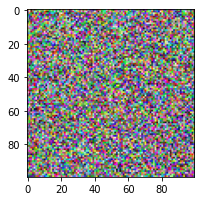

In [ ]:
plt.figure(figsize=(3,4))
plt.imshow(tf.cast(adversarial_patch[0], tf.uint8))
plt.show()

In [ ]:
# Attach a patch on the image at area of the bounding_box, arg and return ndarray objects
def attach_adversarial_patch(img, bounding_box, patch):
  IMG_RATIO = 0.5
  # IMG_ROTATION = 0.0
  # IMG_BRIGHTNESS = 0.0

  (img_length, img_width, _) = img.shape

  ymin = int(bounding_box[0] * img_length)
  xmin = int(bounding_box[1] * img_width)
  ymax = int(bounding_box[2] * img_length)
  xmax = int(bounding_box[3] * img_width)

  bbox_length = ymax - ymin
  bbox_width = xmax - xmin

  # Convert image to PIL Image object
  img = Image.fromarray(img)
  patch = Image.fromarray(patch)

  # Resize patch to fit in the box
  if bbox_width < bbox_length:
    patch_size = int(bbox_width * IMG_RATIO)
  else:
    patch_size = int(bbox_length * IMG_RATIO)

  patch = patch.resize((patch_size, patch_size))

  # Attach the patch to bounding box
  xstart = int(xmax - bbox_width/2 - patch_size/2)
  ystart = int(ymax - bbox_length/2 - patch_size/2)
  img.paste(patch, (xstart, ystart))

  return np.array(img)

In [ ]:
def attach_adversarial_patch_to_person_via_gt(image, groundtruth_boxes, groundtruth_classes, adversarial_patch):
  person_class_index = 1
  label_id_offset = 1

  num_of_detection = groundtruth_boxes.get_shape().as_list()[0]

  new_img = tf.cast(image, dtype=tf.uint8).numpy()[0]
  patch = tf.cast(adversarial_patch, dtype=tf.uint8).numpy()[0]

  for detection in range(num_of_detection):
    if tf.argmax(groundtruth_classes, axis=1)[detection] + label_id_offset == person_class_index:
      new_img = attach_adversarial_patch(new_img, groundtruth_boxes[detection].numpy(), patch)
  
  new_img = tf.expand_dims(tf.convert_to_tensor(new_img, dtype=tf.float32), axis=0)

  return new_img

## Dataset

In [ ]:
ds_train_full, ds_test_full = tfds.load('coco/2017', split=['train', 'test'], data_dir='/content/tensorflow_datasets')

In [ ]:
ds_train = ds_train_full.take(50)
ds_test = ds_test_full.take(10)

In [ ]:
# Convert tf.data.Dataset to lists of tensors (Questionable)
label_id_offset = 1
num_classes = 90

ds_train_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
gt_is_crowd_tensors = []

for step, ds_train_element in enumerate(ds_train):
  # A list of image tf.float32 tensors with shape [1, None, None, 3]
  ds_train_tensors.append(tf.expand_dims(tf.cast(ds_train_element['image'], dtype=tf.float32), axis=0))

  # A list of 2-D tf.float32 tensors with shape [num_boxes, 4], normalised and clipped
  gt_box_tensors.append(ds_train_element['objects']['bbox'])

  # A list of 2-D tf.float32 one-hot tensor of shape [num_boxes, num_classes]
  gt_classes_one_hot_tensors.append(tf.one_hot(ds_train_element['objects']['label'], num_classes))

  # A list of 1-D tf.bool with shape [num_boxes]
  gt_is_crowd_tensors.append(ds_train_element['objects']['is_crowd'])

## Load Faster R-CNN Model

Download pretrained model from TensorFlow Object Detection Model Zoo (Link: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

Reference: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_checkpoint.html

In [ ]:
# Download and extract model
# Downloaded files are stored in Keras cache
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

In [ ]:
# Download label map
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [ ]:
# Try it out:
%%capture
detect_fn(tf.zeros([1, 640, 640, 3]))

INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


## Inference Test

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (1, img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16)):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  
  print("Annotated Image: ")
  plt.figure(figsize=figsize)
  plt.imshow(image_np_with_annotations)
  plt.show()

Input Image: 


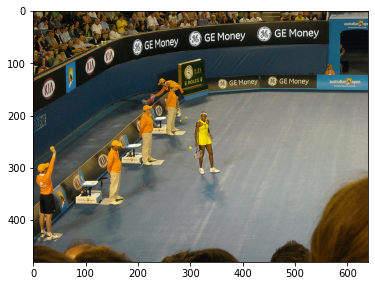

Annotated Image: 


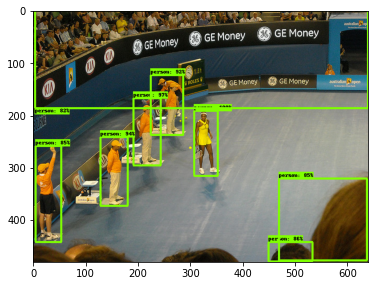

In [ ]:
# Inference test using example image from dataset or an image from the internet
from_dataset = True

if from_dataset is True:
  img = list(ds_train.as_numpy_iterator())[4]
  img = tf.expand_dims(img['image'], axis=0)
  input = tf.cast(img, tf.float32)
else:
  img_path = "https://pixnio.com/free-images/2017/04/20/2017-04-20-10-33-32-900x647.jpg"
  img = load_image_into_numpy_array(img_path)
  input = tf.convert_to_tensor(img, dtype=tf.float32)

print("Input Image: ")
plt.figure(figsize=(6, 8))
plt.imshow(img[0])
plt.show()

(preprocessed_input, true_image_shape) = detection_model.preprocess(input)
prediction = detection_model.predict(preprocessed_input, true_image_shape)
postprocessed_prediction = detection_model.postprocess(prediction, true_image_shape)

label_id_offset = 1

plot_detections(
    img[0].numpy(),
    postprocessed_prediction['detection_boxes'][0].numpy(),
    postprocessed_prediction['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
    postprocessed_prediction['detection_scores'][0].numpy(),
    category_index,
    figsize=(6, 8))

## Loss Function (Unused)

In [ ]:
def loss_function_testing(batch, prediction):
  person_class_index = 1
  num_of_people_detected = []

  for image in range(batch):
    num_of_people_detected.append(tf.math.count_nonzero(tf.cast(tf.math.equal(prediction[batch]['detection_classes'], person_class_index - 1), tf.int8)))

  loss = tf.reduce_mean(num_of_people_detected)

  return loss

## Training Loop

Reference: https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

For future reference: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#end-to-end_example_a_gan_training_loop_from_scratch


In [ ]:
tf.keras.backend.set_learning_phase(True)

# Hyperparameters
learning_rate = 0.01
batch_size = 5
num_batches = 1

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, training_variable):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      tape.watch(training_variable)

      # To-do: Attach adversarial patch here
      for idx, image_tensor in enumerate(image_tensors):
        image_tensor = tf.py_function(func=attach_adversarial_patch_to_person_via_gt,
                                      inp=[image_tensor, groundtruth_boxes_list[idx], groundtruth_classes_list[idx], training_variable],
                                      Tout=tf.float32)

      preprocessed_images = tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], 
                                      axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/BoxClassifierLoss/localization_loss'] + losses_dict['Loss/BoxClassifierLoss/classification_loss']
      gradients = tape.gradient(total_loss, training_variable)
      # Debug:
      print(gradients)
      # optimizer.apply_gradients(zip(gradients, training_variable))
    return total_loss

  return train_step_fn

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
optimiser = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimiser, adversarial_patch)

In [ ]:
import random
import warnings

# Suppress warnings from detection model library for debugging
warnings.filterwarnings('ignore')

print('Start training...', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples: Generate ID's (keys) for each dataset element,
  # then randomly take a number of keys equal to batch size
  all_keys = list(range(len(ds_train)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [ds_train_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done training...!')

warnings.filterwarnings('default')

Start training...
None
batch 0 of 1, loss=1.1325703
Done training...!


## Results